# Multi-Head Attention – Toy-Notebook (2 Heads)

Zwei Heads betrachten denselben Satz mit unterschiedlichen Projektionen.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

np.set_printoptions(suppress=True, precision=3)


## 1) Satz und Embeddings

In [2]:
tokens = ["Paris", "ist", "Hauptstadt", "von", "Frankreich"]
X = np.array([
    [2.0, 0.0, 1.0, 1.0],
    [0.0, 1.5, 0.0, 1.0],
    [0.0, 0.5, 2.5, 1.0],
    [1.0, 2.0, 0.5, 0.0],
    [2.0, 0.0, 1.5, 0.5],
], dtype=float)
pd.DataFrame(X, index=tokens, columns=["x1","x2","x3","x4"])


,x1,x2,x3,x4
Paris,2.0,0.0,1.0,1.0
ist,0.0,1.5,0.0,1.0
Hauptstadt,0.0,0.5,2.5,1.0
von,1.0,2.0,0.5,0.0
Frankreich,2.0,0.0,1.5,0.5


## 2) Zwei Head-Projektionen definieren

In [3]:
WQ1 = np.array([[1,0],[0,1],[0,0],[0,0]], dtype=float)
WK1 = np.array([[0.8,0],[0,1.0],[0,0],[0,0]], dtype=float)
WV1 = np.array([[1,0],[0,1],[0,0],[0,0]], dtype=float)

WQ2 = np.array([[0,0],[0,0],[1,0],[0,1]], dtype=float)
WK2 = np.array([[0,0],[0,0],[1.0,0],[0,0.8]], dtype=float)
WV2 = np.array([[0,0],[0,0],[1,0],[0,1]], dtype=float)

heads = {"Head 1": (WQ1, WK1, WV1), "Head 2": (WQ2, WK2, WV2)}
print("Head-Dimension:", WQ1.shape[1])


Head-Dimension: 2


## 3) Attention pro Head berechnen

In [4]:
def softmax(x, axis=-1):
    x = x - np.max(x, axis=axis, keepdims=True)
    e = np.exp(x)
    return e / e.sum(axis=axis, keepdims=True)

results = {}
for name, (WQ, WK, WV) in heads.items():
    Q, K, V = X @ WQ, X @ WK, X @ WV
    S = (Q @ K.T) / np.sqrt(Q.shape[1])
    A = softmax(S, axis=1)
    C = A @ V
    results[name] = {"Q": Q, "K": K, "V": V, "S": S, "A": A, "C": C}

idx_von = tokens.index("von")
for name in results:
    print(name, "Kontextvektor fuer von:", np.round(results[name]["C"][idx_von], 3))


Head 1 Kontextvektor fuer von: [0.91  1.577]
Head 2 Kontextvektor fuer von: [1.373 0.736]


## 4) Attention-Matrizen visualisieren

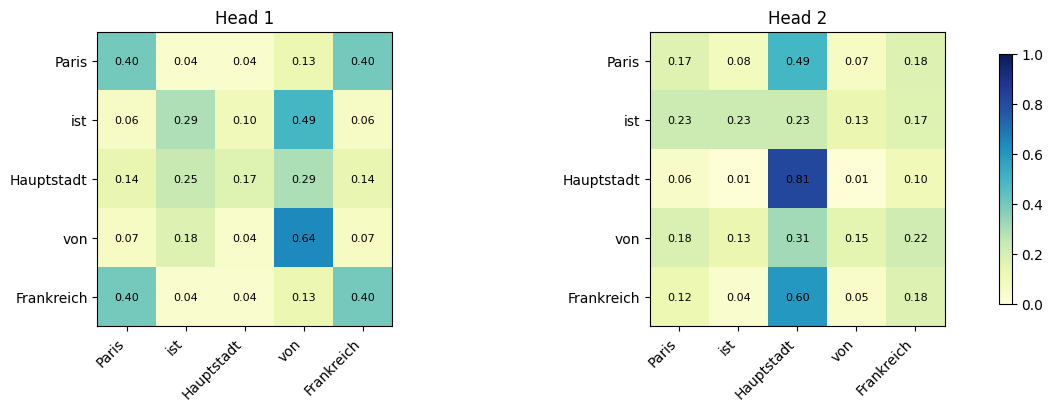

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4), constrained_layout=True)
for ax, (name, r) in zip(axes, results.items()):
    A = r["A"]
    im = ax.imshow(A, cmap="YlGnBu", vmin=0, vmax=1)
    ax.set_title(name)
    ax.set_xticks(range(len(tokens)), tokens, rotation=45, ha="right")
    ax.set_yticks(range(len(tokens)), tokens)
    for i in range(len(tokens)):
        for j in range(len(tokens)):
            ax.text(j, i, f"{A[i,j]:.2f}", ha="center", va="center", fontsize=8)
fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.85)
plt.show()


## 5) Vergleich für das Token `von`

In [6]:
row = tokens.index("von")
pd.DataFrame({
    "Token": tokens,
    "Head1_alpha": results["Head 1"]["A"][row],
    "Head2_alpha": results["Head 2"]["A"][row],
}).set_index("Token").round(3)


,Head1_alpha,Head2_alpha
Token,,
Paris,0.067,0.184
ist,0.180,0.129
Hauptstadt,0.044,0.313
von,0.643,0.154
Frankreich,0.067,0.220


## 6) Head-Ausgaben konkatenieren

In [7]:
C_concat = np.hstack([results["Head 1"]["C"], results["Head 2"]["C"]])
pd.DataFrame(C_concat, index=tokens, columns=["h1_c1","h1_c2","h2_c1","h2_c2"]).round(3)


,h1_c1,h1_c2,h2_c1,h2_c2
Paris,1.708,0.337,1.714,0.840
ist,0.728,1.469,1.137,0.781
Hauptstadt,0.871,1.041,2.258,0.934
von,0.910,1.577,1.373,0.736
Frankreich,1.708,0.337,1.922,0.855


## 7) Einordnung

- Mehrere Heads erlauben unterschiedliche Relationen/Features parallel.
- In echten Transformern werden diese Projektionen gelernt und danach weiter verarbeitet.